In [252]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
import pandas as pd
import warnings
import io
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [332]:
from google.colab import files


uploaded = files.upload()

Saving Bitcoin Data.csv to Bitcoin Data.csv


Text(0.5, 0, 'Date (2021/06 - 2023/06)')

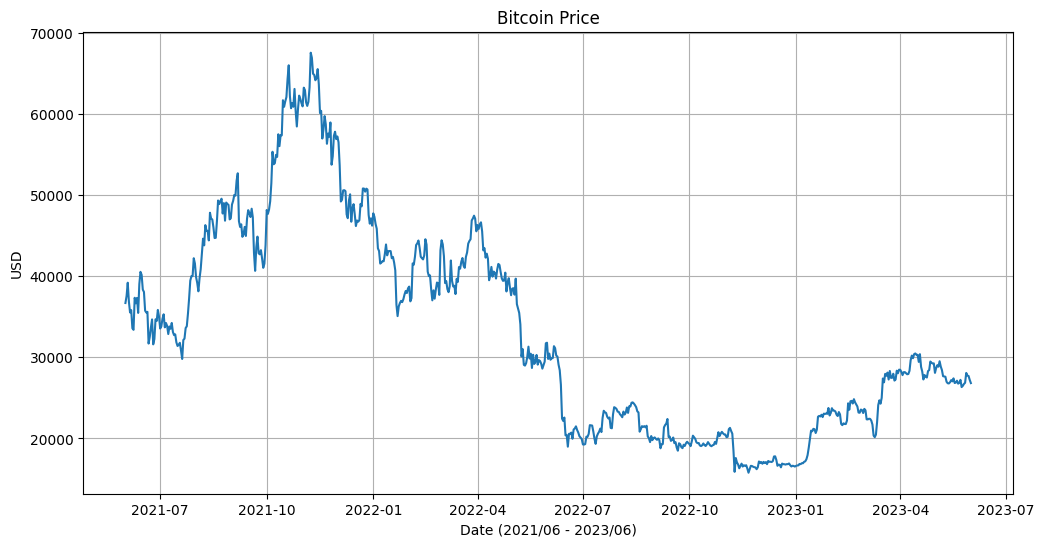

In [333]:
data = pd.read_csv(io.BytesIO(uploaded['Bitcoin Data.csv']))

# Chuyển cột 'Date' sang kiểu dữ liệu ngày tháng
data['Date'] = pd.to_datetime(data['Date'])

# Tạo cột 'Month' để lưu giá trị tháng
data['Month'] = data['Date'].dt.month


# Chọn cột giá Bitcoin (giả sử là cột 'Price') và cột tháng (giả sử là cột 'Month')
x = data['Date']
y = data['Close']

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.grid(True)

# Đặt tiêu đề và nhãn trục
plt.title('Bitcoin Price')
plt.ylabel('USD')
plt.xlabel('Date (2021/06 - 2023/06)')

# Hiển thị đồ thị
#plt.show()

In [258]:
# Định nghĩa hàm adf_test
def adf_test(series, title=''):
    result = adfuller(series)
    print(f'Augmented Dickey-Fuller Test ({title})')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')


adf_test(df['Close'],'Bitcoin Price')

Augmented Dickey-Fuller Test (Bitcoin Price)
ADF Test Statistic: -1.2364501742203706
p-value: 0.6577225931322177
#Lags Used: 0
Number of Observations Used: 730
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [259]:
#Tính sai phân bậc 1
df['diff1'] = df['Close'].diff()
# Ghép cột 'diff1' với cột 'Date'
df_with_diff1 = pd.concat([data['Date'], df['Close'], df['diff1']], axis=1)
df_with_diff1

,Date,Close,diff1
0,2021-06-01,36687.6,NaN
1,2021-06-02,37555.8,868.2
2,2021-06-03,39187.3,1631.5
3,2021-06-04,36851.3,-2336.0
4,2021-06-05,35520.0,-1331.3
...,...,...,...
726,2023-05-28,28071.2,1213.7
727,2023-05-29,27739.4,-331.8
728,2023-05-30,27698.2,-41.2
729,2023-05-31,27216.1,-482.1


In [260]:
# Thay thế giá trị vô hạn (inf) bằng NaN
#df['diff1'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Loại bỏ các hàng chứa giá trị NaN
df.dropna(subset=['diff1'], inplace=True)

adf_test(df['diff1'],'Bitcoin Price at first Difference')

Augmented Dickey-Fuller Test (Bitcoin Price at first Difference)
ADF Test Statistic: -20.600763795914972
p-value: 0.0
#Lags Used: 1
Number of Observations Used: 728
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [261]:
df_scaled = pd.concat([data['Date'], df2['Close']], axis=1)
#df_scaled
df2['Close']

0      36687.6
1      37555.8
2      39187.3
3      36851.3
4      35520.0
        ...   
726    28071.2
727    27739.4
728    27698.2
729    27216.1
730    26819.0
Name: Close, Length: 731, dtype: float64

In [279]:
df_scaled = pd.concat([data['Date'], df2['Close']], axis=1)
scaler = StandardScaler()
df_scaled['Close']= scaler.fit_transform(df_scaled['Close'].values.reshape(-1,1))
df_scaled = df_scaled[['Close']]
df_scaled

,Close
0,0.281676
1,0.349129
2,0.475886
3,0.294394
4,0.190961
...,...
726,-0.387760
727,-0.413539
728,-0.416740
729,-0.454196


In [263]:
interrupt = int(len(df_scaled)*.7)
interrupt

511

In [264]:
itrain_data, itest_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(itrain_data.shape)
print(itest_data.shape)

(511, 1)
(220, 1)


In [280]:
# Split the data into training, testing, and validation sets 7:2:1
train_size = int(0.7 * len(df_scaled))
test_size = int(0.2 * len(df_scaled))
val_size = len(df) - train_size - test_size

train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:train_size+test_size]
val_data = df_scaled[train_size+test_size:]

In [288]:
print(train_size)
print(test_size)
print(val_size)

511
146
73


In [289]:
warnings.filterwarnings('ignore')

def arima_model(ts_data):
  fit_model = auto_arima(ts_data, test = 'adf', seasonal=False, trace=True)
  print(fit_model.summary())
  return fit_model

In [290]:
fitted = arima_model(train_data)
fitted.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-822.794, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-819.782, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-817.783, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-817.784, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-821.475, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-817.413, Time=1.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-817.704, Time=0.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-819.885, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-819.973, Time=4.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-816.475, Time=1.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-815.658, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-815.707, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-818.955, Time=3.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-824.463, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  511
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 417.232
Date:                Mon, 19 Jun 2023   AIC                           -824.463
Time:                        18:09:29   BIC                           -803.291
Sample:                             0   HQIC                          -816.163
                                - 511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2761      0.011     24.825      0.000       0.254       0.298
ar.L2         -0.9901      0.010   -100.421      0.000      -1.009      -0.971
ma.L1         -0.2603      0.017    -15.007      0.000      -0.294      -0.226
ma.L2          0.9778      0.018     54.301      0.000       0.942       1.013
sigma2         0.0114      0.001     22.386      0.000       0.010       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                96.10
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [291]:
#Tiến hành dự báo trên tập test
pred_test = fitted.predict(len(test_data))
pred_test

#Tiến hành dự báo trên tập valid
pred_val = fitted.predict(len(val_data))
pred_val

511   -1.068141
512   -1.065165
513   -1.062993
514   -1.065339
515   -1.068138
         ...   
580   -1.065864
581   -1.067491
582   -1.065889
583   -1.063836
584   -1.064855
Length: 74, dtype: float64

In [284]:
#Chuyển dữ liệu về miến giá trị ban đầu
actual = column_or_1d(test_data)
pred_test = column_or_1d(pred_test)
pred_val = column_or_1d(pred_val)

inv_actual = scaler.inverse_transform(actual.reshape(-1,1))
inv_pred_test = scaler.inverse_transform(pred_test.reshape(-1,1))
inv_pred_val = scaler.inverse_transform(pred_val.reshape(-1,1))

In [271]:
mae = mean_absolute_error(inv_actual, inv_pred_test)
mape = mean_absolute_percentage_error(inv_actual, inv_pred_test)
mse = mean_squared_error(inv_actual, inv_pred_test)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2807.54
MAPE: 14.08%
MSE: 9409507.18
RMSE: 3067.49


## based models comparisons 7-2-1 split


In [335]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
#df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = df721[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [336]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8832.215, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8834.083, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8834.076, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8830.522, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8835.980, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.328 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [337]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [338]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5
 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5
 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5 19331.5
 19331.5 19331.5 19331.5]


In [339]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 8811.248500201165
Testing RMSE: 3183.437860647313


Validation RMSE: 8811.248500201165
Testing RMSE: 3183.437860647313


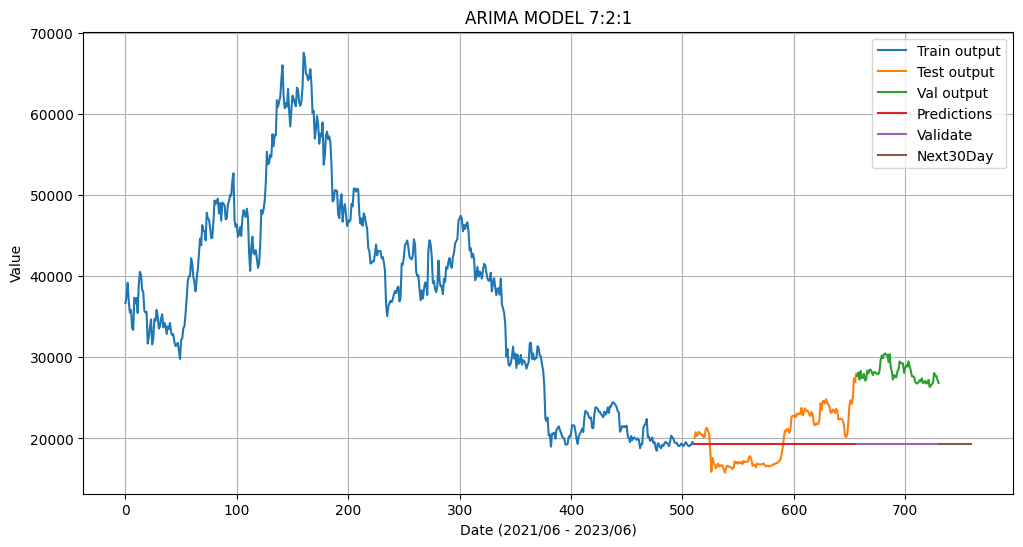

In [340]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.figure(figsize=(12, 6))
plt.title('ARIMA MODEL 7:2:1')
plt.xlabel('Date (2021/06 - 2023/06)')
plt.ylabel('Value')
plt.grid(True)
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train output', 'Test output','Val output', 'Predictions','Validate','Next30Day'])
plt.show()


In [341]:
mae = mean_absolute_error(test_data, y_pred)
mape = mean_absolute_percentage_error(test_data, y_pred)
mse = mean_squared_error(test_data, y_pred)
rmse = np.sqrt(mse)
print('-TEST-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

-TEST-
MAE: 2884.32
MAPE: 14.22%
MSE: 10134276.61
RMSE: 3183.44


In [342]:
mae = mean_absolute_error(val_data, y_pred_val)
mape = mean_absolute_percentage_error(val_data, y_pred_val)
mse = mean_squared_error(val_data, y_pred_val)
rmse = np.sqrt(mse)
print('-VALID-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

-VALID-
MAE: 8747.13
MAPE: 31.06%
MSE: 77638100.13
RMSE: 8811.25


## based models comparisons 6-2-2 split


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7621.450, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7625.011, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7626.860, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7626.850, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7623.170, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7629.962, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7629.933, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7628.755, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7631.509, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7631.319, Time=0.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7619.564, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7628.0

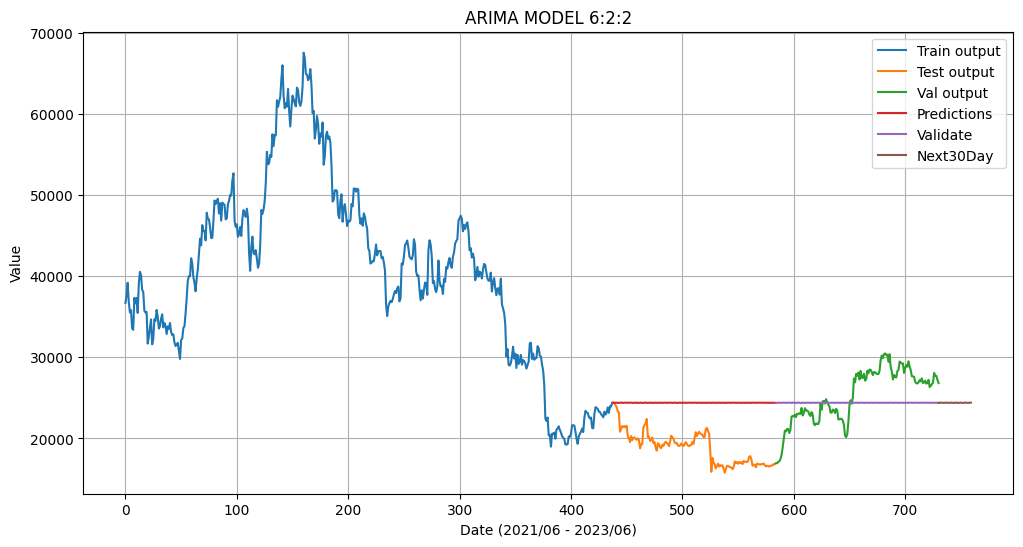

In [343]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
#df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = df622[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.figure(figsize=(12, 6))
plt.title('ARIMA MODEL 6:2:2')
plt.xlabel('Date (2021/06 - 2023/06)')
plt.ylabel('Value')
plt.grid(True)
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train output', 'Test output','Val output', 'Predictions','Validate','Next30Day'])
plt.show()




In [346]:
mae = mean_absolute_error(test_data, y_pred)
mape = mean_absolute_percentage_error(test_data, y_pred)
mse = mean_squared_error(test_data, y_pred)
rmse = np.sqrt(mse)
print('-TEST-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

mae = mean_absolute_error(val_data, y_pred_val)
mape = mean_absolute_percentage_error(val_data, y_pred_val)
mse = mean_squared_error(val_data, y_pred_val)
rmse = np.sqrt(mse)
print('-VALID-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

-TEST-
MAE: 5547.81
MAPE: 30.81%
MSE: 34658331.54
RMSE: 5887.13
-VALID-
MAE: 2960.56
MAPE: 11.93%
MSE: 11637917.74
RMSE: 3411.44


## based models comparisons 8-1-1 split


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10030.197, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10032.048, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10032.040, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10028.590, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10033.903, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.873 seconds
Predicted closing prices for the next 30 days:
[16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8
 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8
 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8 16829.8
 16829.8 16829.8 16829.8]
Validation RMSE: 11298.76093531403
Testing RMSE: 6048.219638959542
Validation RMSE: 11298.76093531403
Testing RMSE: 6048.219638959542


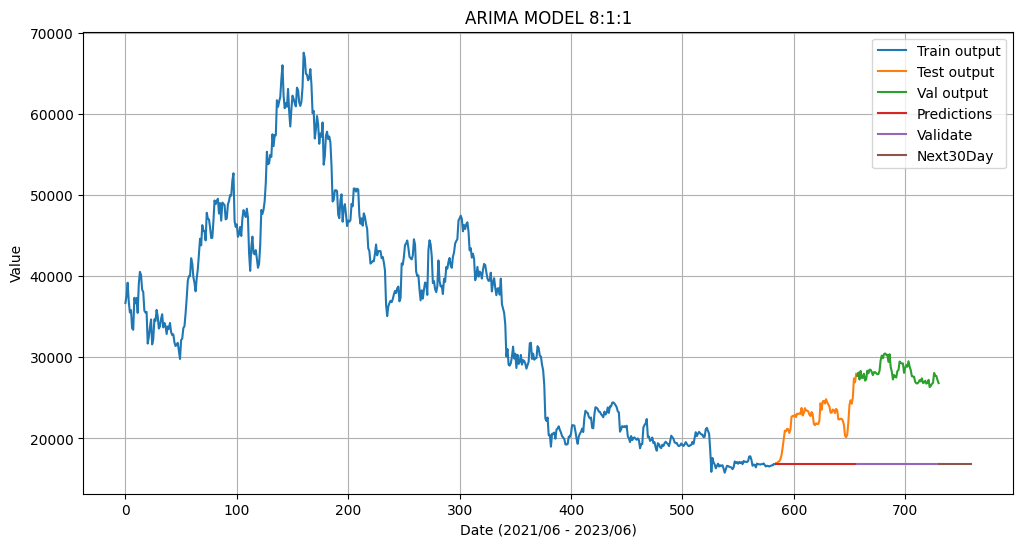

In [348]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
#df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = df811[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.figure(figsize=(12, 6))
plt.title('ARIMA MODEL 8:1:1')
plt.xlabel('Date (2021/06 - 2023/06)')
plt.ylabel('Value')
plt.grid(True)
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train output', 'Test output','Val output', 'Predictions','Validate','Next30Day'])
plt.show()




In [349]:
mae = mean_absolute_error(test_data, y_pred)
mape = mean_absolute_percentage_error(test_data, y_pred)
mse = mean_squared_error(test_data, y_pred)
rmse = np.sqrt(mse)
print('-TEST-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

mae = mean_absolute_error(val_data, y_pred_val)
mape = mean_absolute_percentage_error(val_data, y_pred_val)
mse = mean_squared_error(val_data, y_pred_val)
rmse = np.sqrt(mse)
print('-VALID-')
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

-TEST-
MAE: 5635.36
MAPE: 24.29%
MSE: 36580960.80
RMSE: 6048.22
-VALID-
MAE: 11248.83
MAPE: 39.98%
MSE: 127661998.67
RMSE: 11298.76
